<a href="https://colab.research.google.com/github/alexfc14/fancy-neural-networks/blob/master/Similarity_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Similarity Based Class Encoding

### Introduction

Given a similarity matrix $G$ between classes seen as a *Gram Matrix*, find vectors that satisfy that similarity relationship between them computed as the dot product between class representers $b_i,b_j$ $$g_{ij}=b_i^T b_j$$ If arranged as matrix rows $b_i^T$, 
$$G=B B^T$$

That is, to find such class representer vectors is to find the decomposition $B$. Since $G$ represents a real similarity matrix, it is a symmetric positive definite matrix (no self similarity should be $0$), so it admits many such decompositions:
- the most common being the **Cholesky** decomposition
- another less common being the **eigenvectors times the eigenvalues square root**
- I propose a formula that concentrates values near the diagonal, to approximate one-hot encoding, using a combination of **Householder** tridiagonalization and **Cholesky** decomposition of the tridiagonal matrix.

**Note**: We work with similarity values of $1$ between the same classes and allow $0$ as a minimum. This means that:
- zero entries $g_{ij}=0$ correspond to orthogonal representer vectors $b_i, b_j$
- diagonal entries are one $g_{ii}=b_i^T b_i = 1$, that is, representer vectors are normal, so the dot product is the **cosine distance**.

Following the example of the image classification of "street", "building", "glacier", "mountain" and "seashore" from ImageNet using WordNet similarity, where we developed a loss function $1-yGp$ regardless of the encoding, if we now think of the variable as a feature, we compare the encodings we would get with the 3 different methods.

In [ ]:
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('brown')
from nltk.corpus import brown
ic=wordnet.ic(brown)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


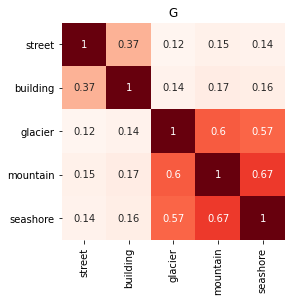

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def similarity_matrix(classes, similarity):
  n=len(classes)
  G=pd.DataFrame(index=classes, columns=classes)
  class_synsets={}
  for class_ in classes:
    class_synsets[class_]=wordnet.synsets(class_)[0]
  for c1,s1 in class_synsets.items():
    for c2, s2 in class_synsets.items():
      s=similarity(s1,s2)
      G[c1][c2]=s
  return G.astype(float)

classes=['street', 'building', 'glacier', 'mountain', 'seashore']
G=similarity_matrix(classes, similarity=lambda s1, s2: wordnet.lin_similarity(s1,s2,ic))
plt.figure(figsize=(4,4))
_=sns.heatmap(G,annot=True,cmap='Reds',cbar=False).set_title('G')

In [ ]:
def plot_mats(G,B,title=''):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
  sns.heatmap(G,annot=True,cmap='Reds',cbar=False,ax=axes[0],xticklabels=False,yticklabels=True).set_title('G')
  #color by the absolute value, annotate the real value of B
  sns.heatmap(np.abs(B),annot=B,cmap='Reds',cbar=False,ax=axes[1],xticklabels=False,yticklabels=False).set_title('B')
  plt.suptitle(title, y=0)
  plt.tight_layout()
  plt.show()

### Choleski encoding

$B=L$ lower triangular from Cholesky decomposition for $G=BB^T$.

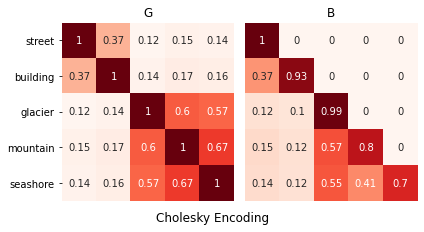

In [ ]:
def cholesky(A):
    n=A.shape[0]
    L=np.zeros((n,n))
    for j in range(n):
        L[j,j]=np.sqrt( A[j,j]-L[j,:j].dot(L[j,:j]) )
        for i in range(j+1,n):
            L[i,j]=( A[i,j]-L[i,:j].dot(L[j,:j]) )/L[j,j]
    np.testing.assert_array_almost_equal(A, L.dot(L.T) )    
    return L

B = cholesky(G.values)
plot_mats(G,B,'Cholesky Encoding')

Observations:
 - Computational efficiency and simplicity.
 - It is clear which class each row vector encodes
 - The structure of clusters from $G$ is visible
 - Asymmetry is bad: the first class only uses the first component, and the last class uses all of them (although it scores low in components of classes from other clusters...), which will create asymetric weights in linear layers, or just produce a bad fit when strongly regularized.

### Eigenvector Encoding

For being a symmetric positive definite matrix, we can diagonalize $G$ into $D$ with an orthogonal ($P^TP=I$) matrix $P$, made of the eigenvectors of $G$, as change of basis

$$G=P D P^T$$

We can take $$B=P\sqrt D$$, where the square root is taken element-wise (only diagonals are non-zero), $S=\sqrt D$

and obtain a new decomposition $BB^T=P\sqrt D \sqrt D P^T=P D P^T = G$ .

eigval sqrt [1.536 1.114 0.794 0.569 0.667]


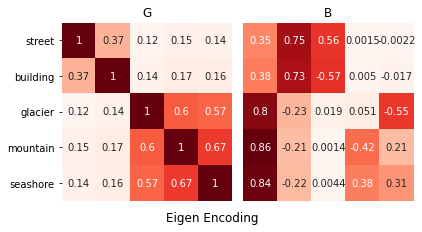

In [ ]:
from numpy.linalg import eig

def eigen_encode(G,print_eigvals=True):
  d, P = eig(G)
  s=np.sqrt(d)
  if print_eigvals:
    print('eigval sqrt', s.round(3))
  np.testing.assert_array_almost_equal(G, P.dot(np.diag(d)).dot(P.T) )
  S=np.diag(s)
  B=P.dot(S)
  np.testing.assert_array_almost_equal(G, B.dot(B.T) )
  return B

B=eigen_encode(G.values)
plot_mats(G,B,'Eigen Encoding')

Observations:
 - representers of similar classes are close
 - the matrix is very unbalanced
 - but it is not arbitrary: the eigenvectors, columns of $P$, are normal vectors, $P^TP=I$, but they get multiplied each by a different eigenvalue square root as $P\sqrt D$, [1.536 1.114 0.794 0.569 0.667]. The first column gets multiplied by the largest, the fourth gets the smallest. In fact, it could be removed with small information loss if small enough, as is done in $PCA$, where correlation plays the role of similarity.

### Householder & Cholesky $Q L Q^T$ Proposal

Other realizations $B'$ can only be $B'=BQ$ for some orthogonal matrix $Q$, ie $QQ^t=I$, since $B'\left(B'\right)^T=BQQ^TB=BB^T=G$.

We wish to find one $B'$ where:
 - the $i$-th class vector should have the highest component at $i$ so we can tell which class it represents
 - the rest of components should be zero or decreasing, but scoring a bit higher for components of similar classes

We know that we can transform a symmetric positive definite matrix $G$ into a triangular symmetric matrix (only 3 central diagonal bands are non-zero) $T$ by $G=Q T Q^T$ using Householder reflections (which are both symmetric and unitary $Q^T=Q$,  $Q^TQ=I$).

Next, we can decompose $T=L L^T$ using Cholesky, to get a lower triangular matrix with zeros everywhere except the diagonal and the subdiagonal, since Cholesky preserves matrix bandedness. Now, $B'=QL$ is also a decomposition of $G$ since $QL(QL)^T=QLL^TQ^T=QTQ^T=G$.

However, such decomposition $QL$ will be far from banded, since $Q$ is the matrix of the norm-preserving transformation that brings $G$ to a space where it is tridiagonal, by left-wise product and right-wise inverse product, as in any change of basis. So if we only apply left-wise product $Q$ to $L$, intuitively, we will get a very offdiagonal matrix. If instead we multiply right-wise by $Q^T$, we get mostly diagonally dominant matrices $B=QLQ^T$.

We check that in the vast majority of cases this is satisfied. Exceptions come from similarity matrices containing very offdiagonal elements in one column.Otherwise, we get encoding vectors which peak at the component of the same class and in a good measure at the components of similar classes.

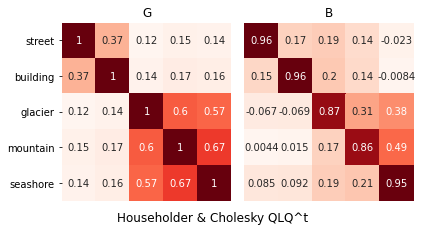

In [ ]:
def householder_P(x):
        u=x.copy()
        s=np.sign(x[0])
        if s==0:
            s=1
        u[0]+=s*np.linalg.norm(x)
        return np.eye(u.shape[0])-2*np.outer(u,u)/np.dot(u.T,u)

def tridiagonal_householder(A):
    """A=Q T Q^T Find a similar tridiagonal matrix to A, T, and the unitary transformation Q made of Householder plane reflections."""
    m,n=A.shape
    Q=np.eye(m)
    T=A.copy()
    
    for i in range(n):
        P=householder_P(T[i:,i-1])
        if P.shape[0]!=m:
            P=np.bmat([[np.eye(i),np.zeros((i,m-i))],
                       [np.zeros((m-i,i)),P]])
        assert (P.T==P).all()
        np.testing.assert_array_almost_equal( P.T.dot(P), np.eye(P.shape[0]) )
        Q=Q.dot(P)
        T=P.dot(T).dot(P)
    return np.array(Q),np.array(T)

def qlqt_encode(G):
  Q,T=tridiagonal_householder(G)
  np.testing.assert_array_almost_equal(G, Q.dot(T).dot(Q.T) )
  L=cholesky(T)
  np.testing.assert_array_almost_equal(T, L.dot(L.T) )
  B=Q.dot(L).dot(Q.T)
  np.testing.assert_array_almost_equal(G, B.dot(B.T) )
  return B

B=qlqt_encode(G.values)
plot_mats(G,B,'Householder & Cholesky QLQ^t')

#### Observations:

- $B=Q L Q^T$ is indeed very symmetric, diagonally dominant
- it is not always exactly decreasing from the diagonal, however.

Remind that $BB^t=G$ for the similarity $G$, where $G=Q T Q^t$, $T$ tridiagonal symmetric, $T=L L^t$, $L$ lower bidiagonal.

We check that the diagonal elements of the encoding being the row maximum happen for about $99\%$ of symmetric positive definite matrices of size 5.

We have observed that failures come from matrices where, if we were to define a distance measure $d_{ij}=1-g_{ij}$, the triangular inequality $d_{ij} \leq d_{ik}+d_{kj}$ does not hold. In terms of similarity, the triangular inequality rewrites $g_{ik}+g_{kj} \leq g_{ij}+1$, and it tells that no pair of dissimilar classes $i,j$ should be so similar to a third class $k$ that their added similarities to the third class exceeds the similarity between them by more than a unit.

If we impose this condition, the success rate is higher than $99.97\%$. More work can be put to investigate why.

We also see that these cases have some very small eigenvalues, so if such a case arises, we may as well use the eigen encoding dropping the corresponding eigenvectors.

In [ ]:
def encodings_comparative_figure(G):
  Gv=np.array(G)
  B1 = cholesky(Gv)
  B2 = eigen_encode(Gv,False)
  B3 = qlqt_encode(Gv)
  
  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 3))
  _=sns.heatmap(G       ,annot=True,cmap='Reds',cbar=False,ax=axes[0],xticklabels=False,yticklabels=True).set_title('Similarity G')
  _=sns.heatmap(np.abs(B1),annot=B1,cmap='Reds',cbar=False,ax=axes[1],xticklabels=False,yticklabels=False).set_title('Cholesky Encoding')
  _=sns.heatmap(np.abs(B2),annot=B2,cmap='Reds',cbar=False,ax=axes[2],xticklabels=False,yticklabels=False).set_title('Eigen Encoding')
  _=sns.heatmap(np.abs(B3),annot=B3,cmap='Reds',cbar=False,ax=axes[3],xticklabels=False,yticklabels=False).set_title('Householder&Cholesky Encoding')
  _=plt.suptitle('Comparison of Encodings',y=0)
  plt.tight_layout()
  plt.show()

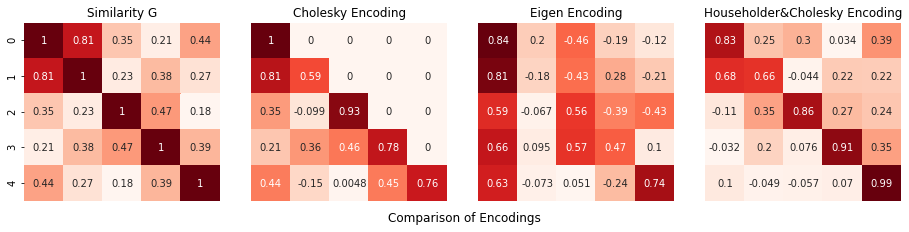

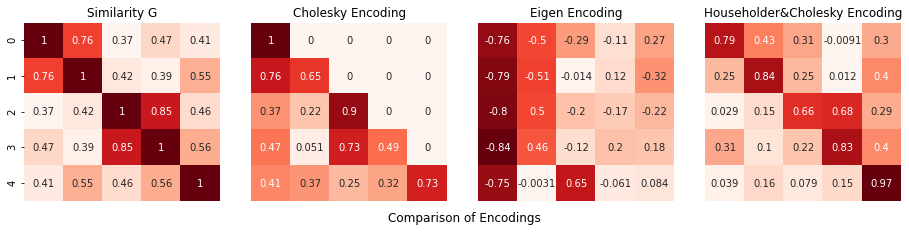

Fail rate 2/10000 = 0.0002


In [ ]:
def check_triangular(G):
  n=G.shape[0]
  for k in range(n):
    for i in range(n):
      for j in range(n):
        if 1+G[i,j]<G[i,k]+G[k,j]:
          return False
  return True

def check_pos_def(G):
  eigvals=np.linalg.eigvals(G)
  if not np.all(eigvals>0):
    return False
  return True
  
def random_pos_def_sym(n):
  G=np.random.rand(n,n)
  i=np.arange(n)
  G[i,i]=1
  G=(G.T+G)/2
  if not check_triangular(G) or not check_pos_def(G):
    G=random_pos_def_sym(n)
  return G

n=5
n_tests=10000
n_fails=0
for k in range(n_tests):
  G=random_pos_def_sym(n)
  Q,T=tridiagonal_householder(G)
  L=cholesky(T)
  B=Q.dot(L).dot(Q.T)
  row_max_idx = np.array(B.argmax(axis=1)).flatten()
  row_diag_idx = np.arange(n)
  try:
    np.testing.assert_array_almost_equal(row_max_idx, row_diag_idx)
  except:
    n_fails+=1
    encodings_comparative_figure(G)
print(f'Fail rate {n_fails}/{n_tests} = {n_fails/n_tests}')

### Conclusions

Let us plot all three approaches for our example in a single figure.

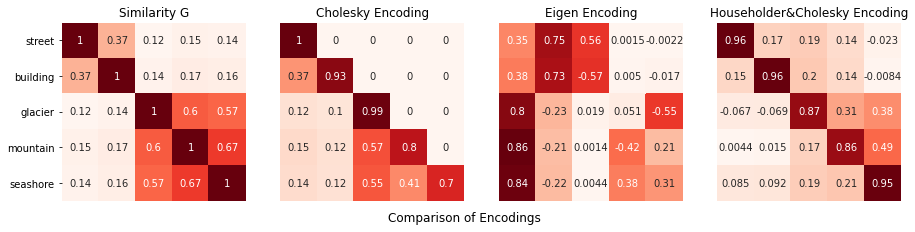

In [ ]:
G=similarity_matrix(classes, similarity=lambda s1, s2: wordnet.lin_similarity(s1,s2,ic))
encodings_comparative_figure(G)

- "Cholesky" encoding is the simplest, most time efficient, and the upper half of the matrix is empty, never the diagonal for positive definite matrices.
- "Eigen" encoding creates relatively close vectors for similar classes, leaves the possibility to drop insignificant columns, but is not very efficient nor precise computationally.
- "Householder & Choleski" creates a mostly diagonally dominant encoding that reminds of the one-hot encoding, but satistifying the decomposition condition.